# Задача

Ускорить шаг алгоритма Метрополиса для двухмерной модели Изинга в задаче 2 в ["Python. Список задач 5. Модель Изинга, алгоритм Метрополиса"](http://theor.mephi.ru/wiki/images/b/b8/Python_problem_set_5.pdf) на странице 8:

$$x_{i, \ j} = \pm 1$$

$$E(x) = - J \sum_{i, \ j} \left(x_{i + 1, \ j} + x_{i, \ j + 1}\right) x_{i, \ j} - h \sum_{i, \ j} x_{i, \ j}$$

$$M(x) = \frac 1 N \sum_{i, \ j} x_{i, \ j}$$

# Решение

In [33]:
from numpy import *
import matplotlib.pyplot as plt
import numba as nb
%load_ext line_profiler
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

@nb.njit
def seed(x):
    random.seed(x)

Найденные формулы для ускорения шага алгоритма Метрополиса:

$$\Delta E_{i, \ j} = 2 J \left( x_{i - 1, \ j} + x_{i, \ j - 1} + x_{i + 1, \ j} + x_{i, \ j + 1} \right) x_{i, \ j} + 2 h x_{i, \ j}$$

$$\Delta M_{i, \ j} = - 2 \frac 1 N x_{i, \ j}$$

Производительная программа `calc_model_nb` для расчета двухмерной модели Изинга алгоритмом Метрополиса:

# Исходный

In [378]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    x_tr = empty((n_side, n_side))
    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side)
            j = random.randint(n_side)

            x_tr[:] = x
            x_tr[i, j] = - x_tr[i, j]
            
            E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
            E_tr = - J * ((x_tr[:-1, 1:] + x_tr[1:, :-1]) * x_tr[:-1, :-1]).sum() - h * x_tr.sum()

            dE = E_tr - E0

            if dE <= 0:
                x[:] = x_tr
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    x[:] = x_tr

            E[k] = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
            M[k] = x.sum() / n_particles

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return x, E_level, C_level, M_level

CPU times: user 3.25 s, sys: 3.18 ms, total: 3.26 s
Wall time: 3.28 s


In [207]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
x, E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)
# %lprun -f calc_model_nb calc_model_nb(x, T, n_step, window, J, h)
# x, E, C, M = calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.37 s


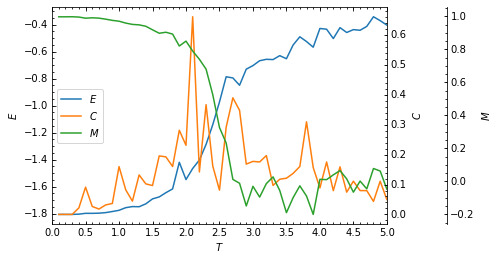

In [208]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

# Оптимизированный в три раза от исходного

In [437]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1
    x = x.copy()

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side)
            j = random.randint(n_side)

            x[i, j] = - x[i, j]
            E_tr = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()

            dE = E_tr - E0

            if dE <= 0:
                E0 = E_tr
                M0 = x.sum() / n_particles
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    E0 = E_tr
                    M0 = x.sum() / n_particles
                else:
                    x[i, j] = - x[i, j]

            E[k] = E0
            M[k] = M0

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return x, E_level, C_level, M_level

CPU times: user 1.49 s, sys: 3.94 ms, total: 1.49 s
Wall time: 1.49 s


In [361]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
x, E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)
# %lprun -f calc_model_nb calc_model_nb(x, T, n_step, window, J, h)
# x, E, C, M = calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 366 ms, sys: 3.5 ms, total: 370 ms
Wall time: 369 ms


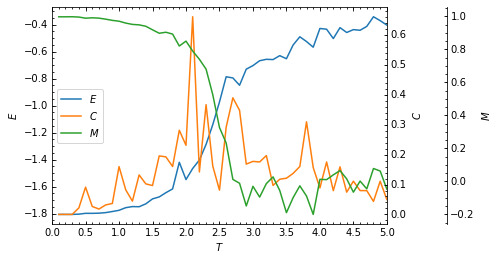

In [362]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

# С формулой для ускорения

In [436]:
%%time
@nb.njit('(int8[:, ::1], float64[::1], int64, int64, float64, float64)')
def calc_model_boosted_nb(x, T_level, n_iterations, window, J, h):
    k_Boltzmann = 1
    x = x.copy()

    n_side, n_side = x.shape
    n_particles = n_side * n_side
    n_levels, = T_level.shape

    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E_level = empty(n_levels)
    C_level = empty(n_levels)
    M_level = empty(n_levels)
    E = empty(n_iterations)
    M = empty(n_iterations)
    E[-1] = E0
    M[-1] = M0

    # добавить рамку с шириной 1 со значениями 0
#     x = pad(x, 1)
    x_ = zeros((n_side + 2, n_side + 2), 'int8')
    x_[1:-1, 1:-1] = x
    x = x_

    for l in range(n_levels):
        T = T_level[l]

        for k in range(n_iterations):
            i = random.randint(n_side) + 1
            j = random.randint(n_side) + 1

            dE = 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j]
            dM = 0

            if dE <= 0:
                dM = - 2 * x[i, j] / n_particles
                x[i, j] = - x[i, j]
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    dM = - 2 * x[i, j] / n_particles
                    x[i, j] = - x[i, j]
                else:
                    dE = 0

            E[k] = E[k - 1] + dE
            M[k] = M[k - 1] + dM

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE / n_particles
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM
    
    # убрать рамку
    x = x[1:-1, 1:-1]

    return x, E_level, C_level, M_level

CPU times: user 2.19 s, sys: 4.84 ms, total: 2.2 s
Wall time: 2.21 s


In [288]:
seed(1)

# ----------
n_side = 20
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
# x = random.randint(2, size=(n_side, n_side)) * 2 - 1  # hot
x = full((n_side, n_side), 1, 'int8')  # cold

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
# x, E, C, M = %time calc_model_boosted_nb(x, T, n_step, window, J, h)
x, E, C, M = calc_model_boosted_nb(x, T, n_step, window, J, h)

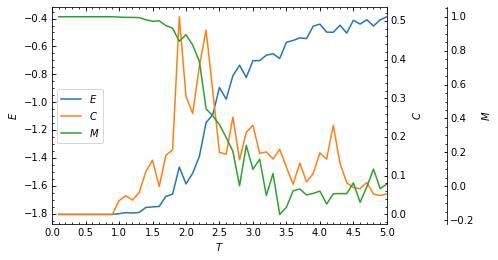

In [289]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

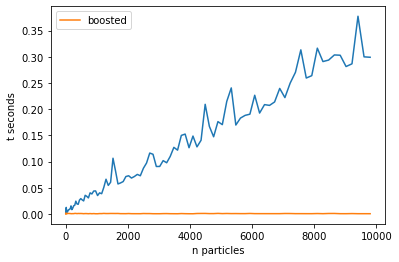

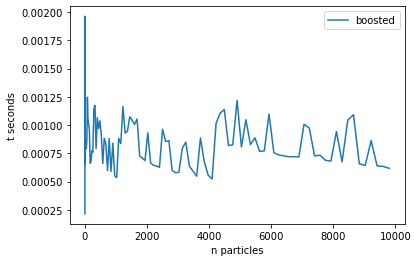

CPU times: user 12.1 s, sys: 21.3 ms, total: 12.1 s
Wall time: 12.4 s


In [505]:
%%time
from timeit import default_timer as timer

def calc_elapsed(func, *args, **kwargs):
    n = 1

    ts = []
    for i in range(n):
        start = timer()
        func(*args, **kwargs)
        ts.append(timer() - start)

    elapsed = min(ts)
    
    return elapsed


J = 1.
h = 0.
n_levels = 1
n_iterations = 10000
window = round(5 / 6 * n_step)
T = full(n_levels, 5.)
n_sides = arange(1, 100)

elapsed = []
elapsed_boosted = []
for n_side in n_sides:
#     x = full((n_side, n_side), 1, 'int8')  # cold
    x = random.randint(2, size=(n_side, n_side), dtype='int8') * 2 - 1  # hot

    elapsed.append(calc_elapsed(calc_model_nb, x, T, n_iterations, window, J, h))
    elapsed_boosted.append(calc_elapsed(calc_model_boosted_nb, x, T, n_iterations, window, J, h))

n_particles = n_sides * n_sides
# plt.subplot(xlabel='n particles', ylabel='t seconds', yscale='log')
plt.subplot(xlabel='n particles', ylabel='t seconds')
plt.plot(n_particles, elapsed)
plt.plot(n_particles, elapsed_boosted, label='boosted')
plt.legend()
plt.show()
plt.subplot(xlabel='n particles', ylabel='t seconds')
plt.plot(n_particles, elapsed_boosted, label='boosted')
plt.legend()
plt.show()

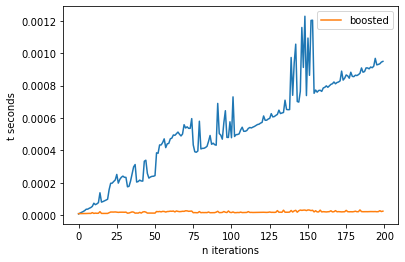

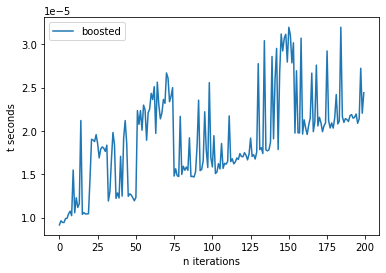

CPU times: user 1.2 s, sys: 3.9 ms, total: 1.21 s
Wall time: 1.22 s


In [504]:
%%time
from timeit import default_timer as timer

def calc_elapsed(func, *args, **kwargs):
    n = 5

    ts = []
    for i in range(n):
        start = timer()
        func(*args, **kwargs)
        ts.append(timer() - start)

    elapsed = min(ts)
    
    return elapsed


J = 1.
h = 0.
n_levels = 1
n_iterationss = arange(0, 200)
window = round(5 / 6 * n_step)
T = full(n_levels, 5.)
n_side = 40

elapsed = []
elapsed_boosted = []
for n_iterations in n_iterationss:
#     x = full((n_side, n_side), 1, 'int8')  # cold
    x = random.randint(2, size=(n_side, n_side), dtype='int8') * 2 - 1  # hot

    elapsed.append(calc_elapsed(calc_model_nb, x, T, n_iterations, window, J, h))
    elapsed_boosted.append(calc_elapsed(calc_model_boosted_nb, x, T, n_iterations, window, J, h))

# plt.subplot(xlabel='n particles', ylabel='t seconds', yscale='log')
plt.subplot(xlabel='n iterations', ylabel='t seconds')
plt.plot(n_iterationss, elapsed)
plt.plot(n_iterationss, elapsed_boosted, label='boosted')
plt.legend()
plt.show()
plt.subplot(xlabel='n iterations', ylabel='t seconds')
plt.plot(n_iterationss, elapsed_boosted, label='boosted')
plt.legend()
plt.show()

Задание состояния генератора случайных чисел для воспроизводимости результата в ноутбуке

In [3]:
seed(0)

Двухмерный массив $x$ имеет размер $(n + 2, n + 2)$, где $n$ -- сторона квадрата системы частиц со спином $-1$ или $1$.

Значения на границе массива равны нулю. Внутри массива могут быть значения $-1$ или $1$, обозначающие состояния частиц.

Начальное состояние всех частиц 1. Все частицы сонаправлены ("холодный" старт симуляции модели).

Длина стороны квадрата системы: $n = 400$.

Число частиц: $n \cdot n = 160000$.

Энергия взаимодействия: $J = 1$.

Магнитное поле выключено: $B = 0$.

In [4]:
n_side = 400  # длина стороны квадрата системы
J = 1  # энергия взаимодействия
B = 0  # магнитное поле выключено
g = 1
mu_b = 1
h = B * g * mu_b
n_particles = n_side * n_side  # число частиц

# создание массива x
n = n_side
# random.seed(0)  # для воспроизводимости результата
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # "горячий" старт
x = full((n + 2, n + 2), 1)  # "холодный" старт

# задание границы массива x со значениями нули
x[0, :] = x[:, 0] = x[n + 1, :] = x[:, n + 1] = 0

Вызов `calc_model_nb` для расчета двухмерной модели Изинга алгоритмом Метрополиса:

In [5]:
# число уровней температуры
n_level = 200
# число шагов алгоритма Метрополиса для одного уровня температуры
# n_step = 1000000
n_step = 10 * n_particles
# ширина окна выборки случайных величин E, C, M для одного уровня температуры
window = round(5 / 6 * n_step)
# уровни температуры в отрезке (0, 5] (ноль исключен)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 47.3 s, sys: 54 ms, total: 47.3 s
Wall time: 33.2 s


Построение графиков энергии $E$, темплоемкости $C$, намагниченности $M$ от температуры $T$:

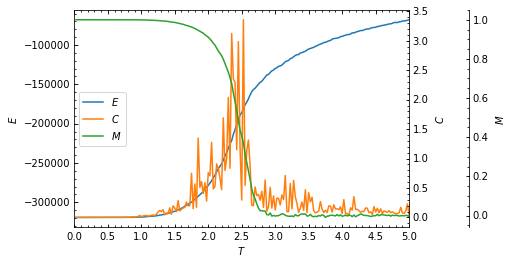

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

Темплоемкость расходится в точке Кюри $T = T_c \approx 2.269185 J$. На графике темплоемкости $C(T)$ приблизительно в $T_c$ наблюдается резкий пик.

Повышение погрешности в окрестности точки Кюри является проблемой критического замедления. Метод параллельного отжига служит решением данной проблемы.  Информация по проблеме критического замедления и методу параллельного отжига есть в материале [Методы канонического и мультиканонического семплирования пространства состояний векторных моделей](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=dvmg&paperid=346&option_lang=rus).

Все потоки процессора не были загружены полностью в процессе расчета модели. Только один поток был полностью загружен. Для полноценной загрузки всех потоков планируется заменить схему решения на ту схему, которая пригодна для распараллеливания на потоки процессора, и распараллелить схему решения с помощью библиотеки Numba на Python. Предположительно, пригодная для данного распараллеливания схема есть по ссылке [Red/Black or Checkerboard Update](http://www.new-npac.org/projects/cdroms/cewes-1999-06-vol1/cps615course/csematerials/applications/mc/montecarlo/node64.html).

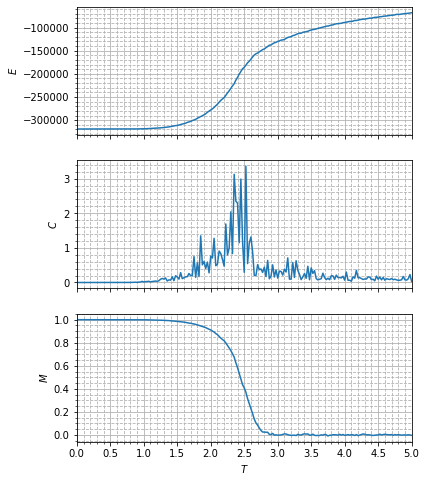

In [7]:
a, b = 1, 2
fig, (axE, axC, axM) = plt.subplots(3, 1, sharex=True, figsize=(a * 6, b * 4))
axM.set_xlabel('$T$')  # Температура
axE.set_ylabel('$E$')  # Энергия
axC.set_ylabel('$C$')  # Темплоемкость
axM.set_ylabel('$M$')  # Намагниченность
axE.plot(T, E)
axC.plot(T, C)
axM.plot(T, M)
axM.set_xlim(0, 5)

for ax in axE, axC, axM:
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
axM.xaxis.set_major_locator(MultipleLocator(0.5))
axM.xaxis.set_minor_locator(AutoMinorLocator())
for ax in axM, axE, axC:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.show()

In [8]:
seed(1)

# ----------
n_side = 40
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
n = n_side
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # hot
x = full((n + 2, n + 2), 1)  # cold
x[0, :] = 0
x[:, 0] = 0
x[n + 1, :] = 0
x[:, n + 1] = 0

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 246 ms


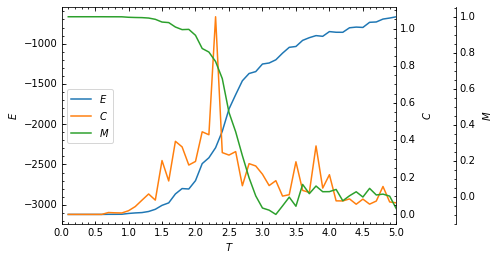

In [9]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

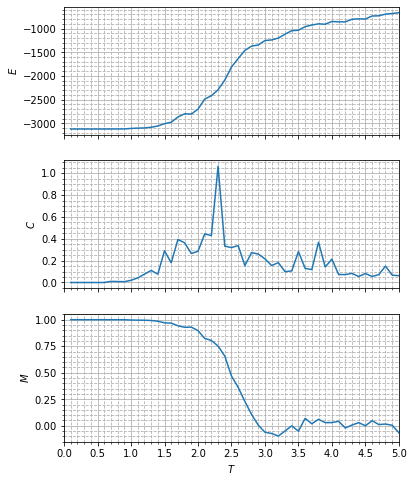

In [10]:
a, b = 1, 2
fig, (axE, axC, axM) = plt.subplots(3, 1, sharex=True, figsize=(a * 6, b * 4))
axM.set_xlabel('$T$')  # Температура
axE.set_ylabel('$E$')  # Энергия
axC.set_ylabel('$C$')  # Темплоемкость
axM.set_ylabel('$M$')  # Намагниченность
axE.plot(T, E)
axC.plot(T, C)
axM.plot(T, M)
axM.set_xlim(0, 5)

for ax in axE, axC, axM:
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
axM.xaxis.set_major_locator(MultipleLocator(0.5))
axM.xaxis.set_minor_locator(AutoMinorLocator())
for ax in axM, axE, axC:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.show()